In [1]:
import torch
from torch import nn
from torch.nn import Conv2d, ConvTranspose2d, Flatten, Linear, BatchNorm2d, ReLU, LeakyReLU, Tanh, Sigmoid
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_shape = (3, 64, 64)

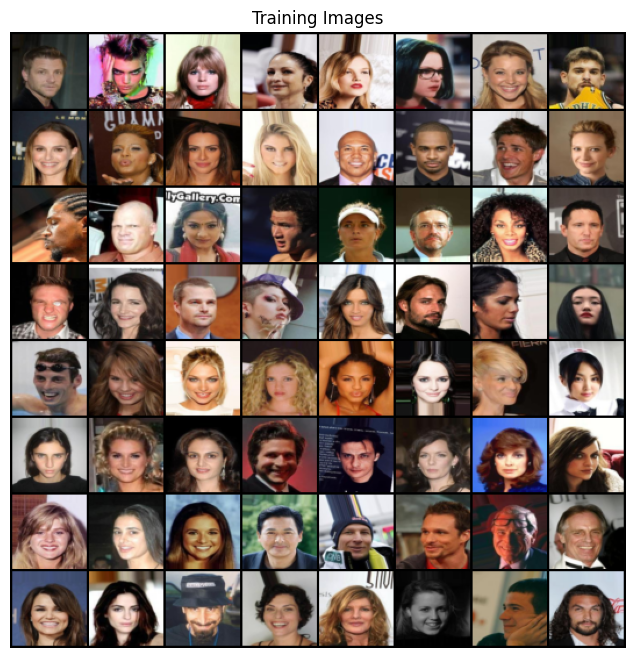

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_shape[1:]),
    transforms.CenterCrop(image_shape[1:]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.ImageFolder(root="./data/celeba",
                                           transform=transform)
batch_size = 64
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class GeneratorNetwork(nn.Module):
    def __init__(self) -> None:
        super(GeneratorNetwork, self).__init__()
        self.main = nn.Sequential(
            # Input Shape z -> (100, 1, 1)
            ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
            BatchNorm2d(1024),
            ReLU(True),

            # (1024, 4, 4)
            ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            BatchNorm2d(512),
            ReLU(True),

            # (512, 8, 8)
            ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            BatchNorm2d(256),
            ReLU(True),

            # (256, 16, 16)
            ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            BatchNorm2d(128),
            ReLU(True),

            #(128, 32, 32)
            ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [6]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            # input shape (3, 64, 64)
            Conv2d(3, 64, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),

            # (64, 32, 32)
            Conv2d(64, 128, 4, 2, 1, bias=False),
            BatchNorm2d(128),
            LeakyReLU(0.2, True),

            #(128, 16, 16)
            Conv2d(128, 256, 4, 2, 1, bias=False),
            BatchNorm2d(256),
            LeakyReLU(0.2, True),

            #(256, 8, 8)
            Conv2d(256, 512, 4, 2, 1, bias=False),
            BatchNorm2d(512),
            LeakyReLU(0.2, True),

            #(512, 4, 4)
            Conv2d(512, 1, 4, 1, 0, bias=False),
            Sigmoid(),

            # (1, 1, 1)
        )
    def forward(self, x):
        return self.main(x)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using Device: ", device)

generator = GeneratorNetwork().to(device)
discriminator = DiscriminatorNetwork().to(device)
generator.apply(weights_init);
discriminator.apply(weights_init);

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))


Using Device:  cuda:0


In [ ]:
num_epochs = 10
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")

for epoch in range(num_epochs):
    print(f"Current on Epoch {epoch + 1}")
    for i, data in enumerate(dataloader, ):
        # Train discriminator
        discriminator.zero_grad()
        real_batch = data[0].to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float32, device=device)
        output = discriminator(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        disc_opt.step()

        # Train Generator
        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        gen_opt.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 250 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))
        iters += 1
